In [1]:
import torch
import os
import pandas as pd
import matplotlib.pyplot as plt
import torchvision.models as models
import seaborn as sns
import numpy as np
import torch.optim as optim
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix, precision_score

In [2]:
import json

# Function to load configurations
def load_config(config_file):
    with open(config_file, 'r') as file:
        config = json.load(file)
    return config

# Load the configuration
config = load_config('config/config.json')

# Access the dataset path
dataset_dir = config['dataset_path']
train_dir = config['train_path']
val_dir = config['val_path']
test_dir = config['test_path']

In [3]:
# Parameters
num_classes = 2  # Update this based on the number of classes in your dataset
batch_size = 16
number_of_epochs = 30
learning_rate = 0.001

In [4]:
# Data transformations
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [5]:
# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = datasets.ImageFolder(root=val_dir, transform=transform)


In [6]:
train_loader = DataLoader(
    train_dataset,
    batch_size = batch_size,
    shuffle = True
)

val_loader = DataLoader(
    val_dataset,
    batch_size = batch_size,
    shuffle = False
)

In [7]:
# Initialize the model
model = models.mobilenet_v2(pretrained=True)

/opt/anaconda3/envs/Thesis/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/Thesis/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
# Modify the classifier to fit the number of classes
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

In [9]:
# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [11]:
# Initialize a dictionary to store metrics
history = {
    'loss': [],
    'val_loss': [],
    'val_accuracy': [],
    'val_precision': []
}

# Train the model
for epoch in range(number_of_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
    
    # Record the loss averaged over the epoch
    epoch_loss = running_loss / len(train_loader.dataset)
    history['loss'].append(epoch_loss)

    # Validate the model
    model.eval()
    val_running_loss = 0.0
    all_predictions = []
    all_labels = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss = val_running_loss / len(val_loader.dataset)
    history['val_loss'].append(val_loss)
    
    accuracy = 100 * (np.array(all_predictions) == np.array(all_labels)).mean()
    precision = precision_score(all_labels, all_predictions, average='macro')
    
    # Record validation metrics
    history['val_accuracy'].append(accuracy)
    history['val_precision'].append(precision)

    print(f'Epoch [{epoch+1}/{number_of_epochs}], Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.2f}%, Precision: {precision:.4f}')

Epoch [1/30], Loss: 0.8199, Val Loss: 0.7685, Accuracy: 50.00%, Precision: 0.5222


/opt/anaconda3/envs/Thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [2/30], Loss: 0.5047, Val Loss: 3.7545, Accuracy: 42.86%, Precision: 0.2143
Epoch [3/30], Loss: 0.3929, Val Loss: 0.7374, Accuracy: 78.57%, Precision: 0.8636
Epoch [4/30], Loss: 0.1783, Val Loss: 0.4141, Accuracy: 82.14%, Precision: 0.8209
Epoch [5/30], Loss: 0.2728, Val Loss: 0.7809, Accuracy: 60.71%, Precision: 0.7963
Epoch [6/30], Loss: 0.1548, Val Loss: 1.6184, Accuracy: 60.71%, Precision: 0.7609
Epoch [7/30], Loss: 0.3568, Val Loss: 1.5918, Accuracy: 60.71%, Precision: 0.7963
Epoch [8/30], Loss: 0.1662, Val Loss: 0.5715, Accuracy: 67.86%, Precision: 0.6846
Epoch [9/30], Loss: 0.0615, Val Loss: 0.7510, Accuracy: 71.43%, Precision: 0.7556
Epoch [10/30], Loss: 0.1275, Val Loss: 2.5782, Accuracy: 60.71%, Precision: 0.6905
Epoch [11/30], Loss: 0.4075, Val Loss: 0.9247, Accuracy: 50.00%, Precision: 0.6042
Epoch [12/30], Loss: 0.3523, Val Loss: 0.7445, Accuracy: 60.71%, Precision: 0.6283
Epoch [13/30], Loss: 0.2993, Val Loss: 0.7596, Accuracy: 64.29%, Precision: 0.6562
Epoch [14/30

/opt/anaconda3/envs/Thesis/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Epoch [20/30], Loss: 0.0697, Val Loss: 6.3686, Accuracy: 42.86%, Precision: 0.2143
Epoch [21/30], Loss: 0.1977, Val Loss: 0.8991, Accuracy: 46.43%, Precision: 0.5174
Epoch [22/30], Loss: 0.1798, Val Loss: 1.2657, Accuracy: 50.00%, Precision: 0.7308
Epoch [23/30], Loss: 0.1080, Val Loss: 2.1842, Accuracy: 53.57%, Precision: 0.6391
Epoch [24/30], Loss: 0.0667, Val Loss: 0.7118, Accuracy: 71.43%, Precision: 0.7292
Epoch [25/30], Loss: 0.0396, Val Loss: 0.6968, Accuracy: 75.00%, Precision: 0.7573
Epoch [26/30], Loss: 0.0979, Val Loss: 3.8948, Accuracy: 46.43%, Precision: 0.7222
Epoch [27/30], Loss: 0.1106, Val Loss: 2.6888, Accuracy: 53.57%, Precision: 0.7400
Epoch [28/30], Loss: 0.1089, Val Loss: 0.5636, Accuracy: 78.57%, Precision: 0.7857
Epoch [29/30], Loss: 0.0964, Val Loss: 1.6424, Accuracy: 53.57%, Precision: 0.6391
Epoch [30/30], Loss: 0.1045, Val Loss: 1.2805, Accuracy: 53.57%, Precision: 0.7400


In [12]:
# Save the model, optional
torch.save(model.state_dict(), f'Pth_Files/Mobilenet_model_{number_of_epochs}.keras')

In [13]:
def predict_class(image_path):
    image = Image.open(image_path).convert('RGB')  # Convert image to RGB if not

    # Apply the transformations
    input_image = transform(image).unsqueeze(0)  # Add batch dimens

    # Predict the class
    with torch.no_grad():  # No need to track gradients for inference
        output = model(input_image)
        _, predicted = torch.max(output.data, 1)  # Get the index of the max log-probability

    # Assuming you have a list of class names corresponding to your label indices
    class_names = ['class1', 'class2']  # Fill in your actual class names
    predicted_class = class_names[predicted.item()]

    print(f'Predicted Class: {predicted_class}')

In [14]:
image_1 = test_dir + "/edible/Agaricus_abruptibulbus/Agaricus_abruptibulbus_1.jpg"
image_2 = test_dir + "/poisonous/Amanita_excelsa/Amanita_excelsa_1.jpg"
image_3 = test_dir + "/edible/Agaricus_abruptibulbus/Agaricus_abruptibulbus_2.jpg"

In [15]:
predict_class(image_1)
predict_class(image_3)
predict_class(image_2)

Predicted Class: class1
Predicted Class: class1
Predicted Class: class1


## Results

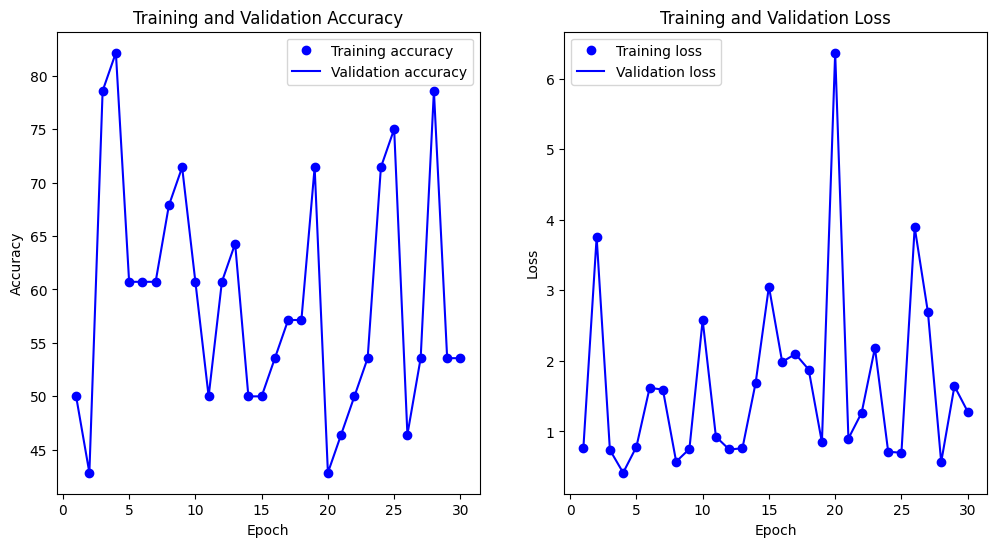

In [16]:
# Plot training & validation accuracy values
acc = history['val_accuracy']
val_acc = history['val_accuracy']
loss = history['val_loss']
val_loss = history['val_loss']
epochs = range(1, len(acc) + 1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

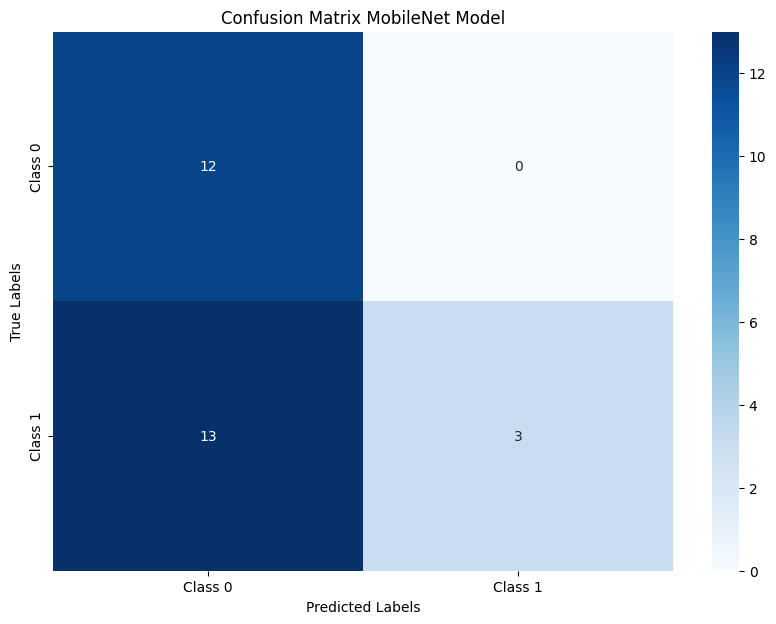

In [17]:
cm = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix MobileNet Model')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [18]:
cr = classification_report(all_labels, all_predictions, target_names=['Class 0', 'Class 1'], output_dict=True)
df_cr = pd.DataFrame(cr).transpose()

print(df_cr)

              precision    recall  f1-score    support
Class 0        0.480000  1.000000  0.648649  12.000000
Class 1        1.000000  0.187500  0.315789  16.000000
accuracy       0.535714  0.535714  0.535714   0.535714
macro avg      0.740000  0.593750  0.482219  28.000000
weighted avg   0.777143  0.535714  0.458443  28.000000
